# Stock Market Prediction: Modeling

In this series of notebooks, I will create a machine learning algorithm to predict the stock price and make a trading recommendation for the user. 

For the following stocks, I will create a trained algorithm:
- *Blue chip stocks*: Blue chip stocks are shares of large, established companies with stable financial performance and low risk.
    - BMW (BMW.DE)
    <p>&nbsp;</p> 
- *Growth stocks*: growth stocks are stocks of companies with high potential for future growth. These stocks often carry higher risks, but also offer higher potential returns
    - Tesla, Inc. (TSLA)
    - Bitcoin (BTC-USD)
    <p>&nbsp;</p>
- *Dividend stocks*: dividend stocks are stocks of companies that pay regular dividends to their shareholders. These stocks often carry lower risks and offer a regular source of income. 
    - Johnson & Johnson (JNJ)
    <p>&nbsp;</p>
- *Small-cap stocks*: small-cap stocks are stocks of small companies with higher risk and higher potential for growth and return.
     - Etsy, Inc (ETSY)

The following algorithms will be tested on their performance:
- Random Forest
- LSTM

This are the one of the most used algorithms for stock prediction. 

The goal is to create an algorithm which can predict the stock prices with a tolerance of ± 5%.
Also, I want to show how the different stock categories influence the accuracy of the algorithm. 

In this notebook, the focus will be to do feature engineering, splitting the data, train the models and validate the performance. 

## Table Of Contents 

#### 1. [Feature Engineering](#fe)  
#### 2. [Random Forest](#rf)
#### 3. [LSTM](#lstm)

In [5]:
# load libraries
import sys

from sqlalchemy import create_engine, text, inspect
import ssl

import pandas as pd
import numpy as np

import ta

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import datetime

## <a class="anchor" id="fe"> 1. Feature Engineering </a>

In [14]:
def load_data(database_filepath):
    '''
    Loading the data from a sql database and transform it to X, y data for the machine learning model.
    
    INPUT 
    database_filepath - (str) path to the sql database
      
    OUTPUT
    Xs - (dict) Features dfs for the stocks
    ys - (dict) Target variables for the stocks
    '''
    # create the engine for the sql database
    engine = create_engine(f'sqlite:///{database_filepath}')
    
    # create a connection
    conn = engine.connect()
    
    # find the table names in the db
    inspector = inspect(engine)
    table_names = inspector.get_table_names()

    # create empty dict
    ys = {}
    Xs = {}
    
    for name in table_names:
        
        # transform to a executable object for pandas
        sql = text("SELECT * FROM '{}'".format(name))
        
        # create the dataframe
        df = pd.read_sql(sql, conn)

        # remove hours, minutes, and seconds from the date
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        # set the date as index
        df = df.set_index('date')
        
        # delete 'Close' column, because the 'Adj Close' is relevant
        df = df.drop('Close', axis=1)
        
        # data split y
        y = df['Adj Close']
        ys[name] = y
        
        # data split X
        X = df.drop(columns=['Adj Close'])
        Xs[name] = X
        

    return Xs, ys


In [15]:
# load data
Xs, ys = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/Data/cleaned_data.db')

I will know explain the new features:

- *Moving Averages (SMA, EMA)*: A moving average calculates the average price of a security or other asset over a specified period of time. The Simple Moving Average (SMA) is the average price over the specified time period. Exponential Moving Average (EMA) is a type of moving average that places more emphasis on the most recent data.
<p>&nbsp;</p>
- *Bollinger Bands*: Bollinger Bands are an indicator of the volatility of securities or other assets. They consist of three lines: a simple moving average line, an upper band line, and a lower band line that are two standard deviations away from the simple moving average.
<p>&nbsp;</p>
- *Average True Range (ATR)*: The Average True Range is a measure of the volatility of a security or other asset. It is the average of the largest daily price movements of a security or asset over a given time period.
<p>&nbsp;</p>
- *MACD*: Moving Average Convergence Divergence (MACD) is an indicator of the trend and momentum changes of a security or other asset. It is calculated by subtracting the 26-period EMA from the 12-period EMA.
<p>&nbsp;</p>
- *RSI*: The Relative Strength Index (RSI) is an indicator of the strength of a trend and potential trend reversal. It is calculated by computing the ratio of average gains and losses over a given period of time.
<p>&nbsp;</p>
- *Stochastic Oscillator*: The Stochastic Oscillator is a momentum indicator that helps identify overbought and oversold conditions. It compares the closing price of a security or other asset to the high-low range over a specified time period.
<p>&nbsp;</p>
- *Stochastic signal*: The Stochastic signal is a signal or trigger line calculated from the moving average of the Stochastic oscillator. It is used to generate buy and sell signals when it crosses above or below the oscillator.

In [4]:
def feat_eng(Xs, ys):
    '''
    Create new features for the X dfs
    
    INPUT 
    Xs - (dict) Feature dfs of the stocks
    ys - (dict) Target variables of the stocks
      
    OUTPUT
    Xs_feat - (dict) extended and normalized X dfs
    ys_feat - (dict) cleaned dfs for the target variable
    '''
    
    Xs_nor, ys_nor, Xs_1, ys_1= {}, {}, {}, {}
    
    for name in Xs:
        
        # define the dfs from the dict
        df = Xs[name]
        y = ys[name]

        # Moving Averages (SMA, EMA)
        df['SMA'] = ta.trend.sma_indicator(y, window=20)
        df['EMA'] = ta.trend.ema_indicator(y, window=20)

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close=y, window=20, window_dev=2)
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Average True Range (ATR)
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=y, window=14)
        df['ATR'] = atr.average_true_range()

        # MACD
        macd = ta.trend.MACD(y, window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()

        # RSI
        df['RSI'] = ta.momentum.RSIIndicator(y, window=14).rsi()

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=y, window=14, smooth_window=3)
        df['Stoch_Oscillator'] = stoch.stoch()
        df['Stoch_Signal'] = stoch.stoch_signal()
        
        # delete all row with no values (because of the new features)
        # find the max rows with nan values
        max_nan_row = max(df.isna().sum())
        df = df.drop(df.index[:max_nan_row])
        y= y.drop(y.index[:max_nan_row])
        
        # normalization of the features
        df_nor = (df - df.min()) / (df.max() - df.min())
        
        # add the df in the dict
        Xs_nor[name] = df_nor
        ys_nor[name] = y_nor
        Xs_1[name] = df
        ys_1[name] = y
        
        
    return Xs_nor, ys_nor, Xs_1, ys_1

In [5]:
# create df dict with new features
Xs_nor, ys_nor, Xs_1, ys_1 = feat_eng(Xs, ys)

In [6]:
def train_test(Xs_nor, ys_nor):
    '''
    Split the data in test and train data for X and y 
    
    INPUT 
    Xs_nor - (dict) Cleaned and normalized feature dfs of the stocks 
    ys_nor - (dict) Normalized target variables of the stocks
      
    OUTPUT
    Xs_train -
    Xs_test -
    ys_train -
    ys_test - 
    '''
    
    Xs_train = {}
    Xs_test = {}
    ys_train = {}
    ys_test = {}
    
    
    for name in Xs_nor:
        X = Xs_nor[name]
        y = ys_nor[name]
        
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        Xs_train[name] = X_train
        Xs_test[name] = X_test
        ys_train[name] = y_train
        ys_test[name] = y_test
    
    return Xs_train, Xs_test, ys_train, ys_test

In [7]:
Xs_train, Xs_test, ys_train, ys_test = train_test(Xs_nor, ys_nor)

## <a class="anchor" id="rf"> 2. Random Forest </a>

In [8]:
# Define the parameter grid
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}


# Create random forest regression object
reg_forest = RandomForestRegressor()

# create empyt dict to fill with r2 scores and the predicted values
r2_train, r2_test = {}, {}
ys_train_predict, ys_test_predict = {}, {}

# create time series object for cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object
grid_search = GridSearchCV(reg_forest, parameters, cv=tscv, scoring='r2')

for name in Xs_train:
    # Fit the GridSearchCV object to the data
    grid_search.fit(Xs_train[name], ys_train[name])

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    
    print('The best hyperparameter for the stock {} are: {}.'.format(name, best_estimator))

    # Get the R^2 scores for the train and test sets
    ys_train_predict[name] = best_estimator.predict(Xs_train[name])
    r2_train[name] = r2_score(ys_train[name], ys_train_predict[name]) 
    ys_test_predict[name] = best_estimator.predict(Xs_test[name])
    r2_test[name] = r2_score(ys_test[name], ys_test_predict[name]) 
    
    diff = sum(ys_test_predict[name]-ys_test[name])

The best hyperparameter for the stock BMW.DE are: RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=150).
The best hyperparameter for the stock BTC-USD are: RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=50).
The best hyperparameter for the stock ETSY are: RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_split=5,
                      n_estimators=150).
The best hyperparameter for the stock JNJ are: RandomForestRegressor(max_features=0.5, min_samples_leaf=2, n_estimators=50).
The best hyperparameter for the stock TSLA are: RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_leaf=2,
                      n_estimators=50).


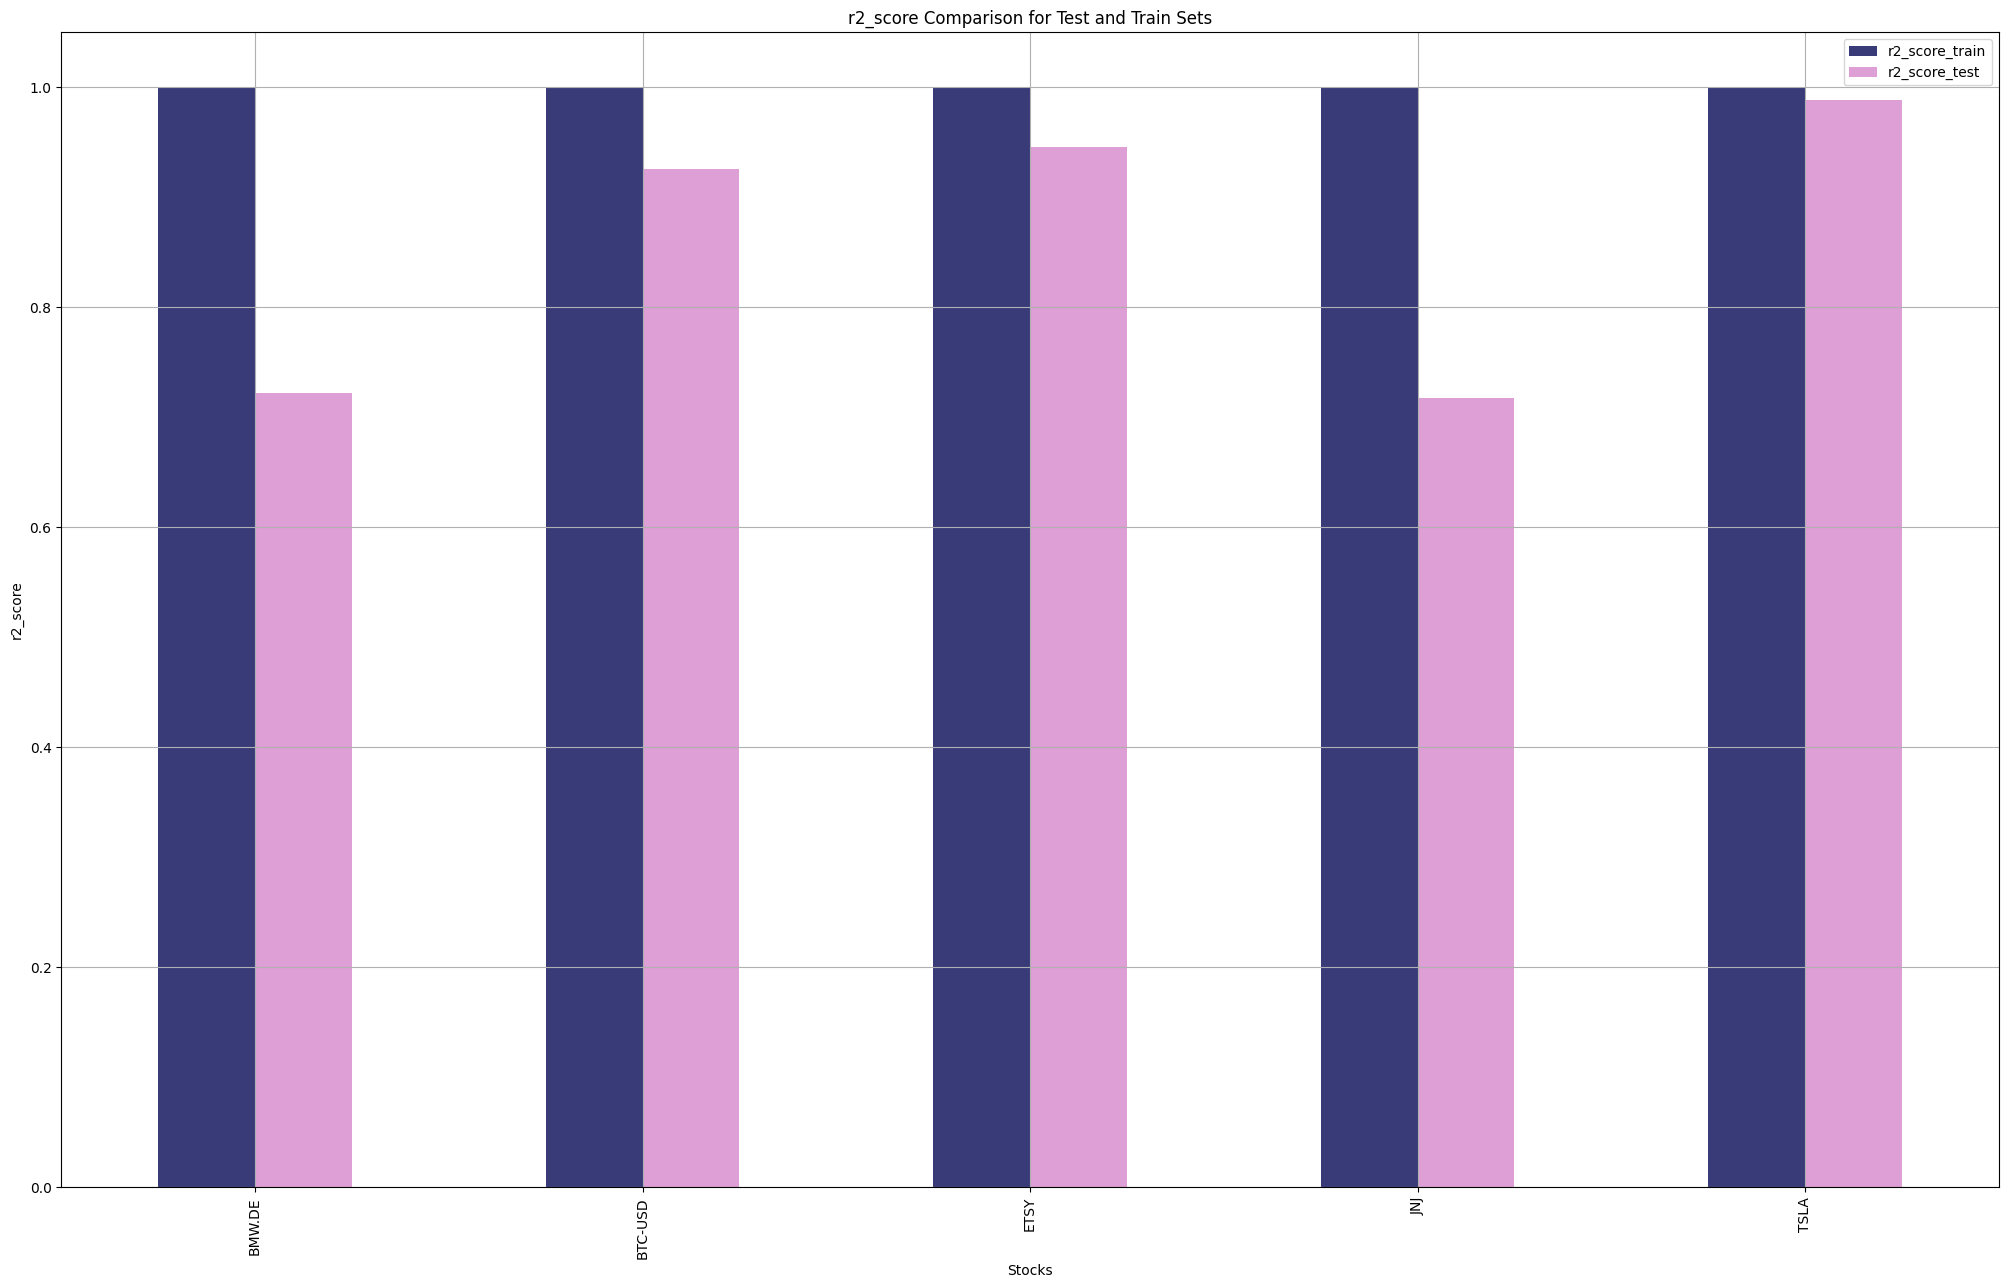

In [9]:
# create dataframes out of the dict
df_train = pd.DataFrame.from_dict(r2_train, orient='index', columns=['r2_score_train'])
df_test = pd.DataFrame.from_dict(r2_test, orient='index', columns=['r2_score_test'])

# Concatenate the dataframes
df_combined = pd.concat([df_train, df_test], axis=1)

# Plot the horizontal stacked bar chart
df_combined.plot(kind='bar', stacked=False, figsize=(25,15), colormap='tab20b')
plt.xlabel('Stocks')
plt.ylabel('r2_score')
plt.title('r2_score Comparison for Test and Train Sets')
plt.grid()
plt.show()

BMW.DE


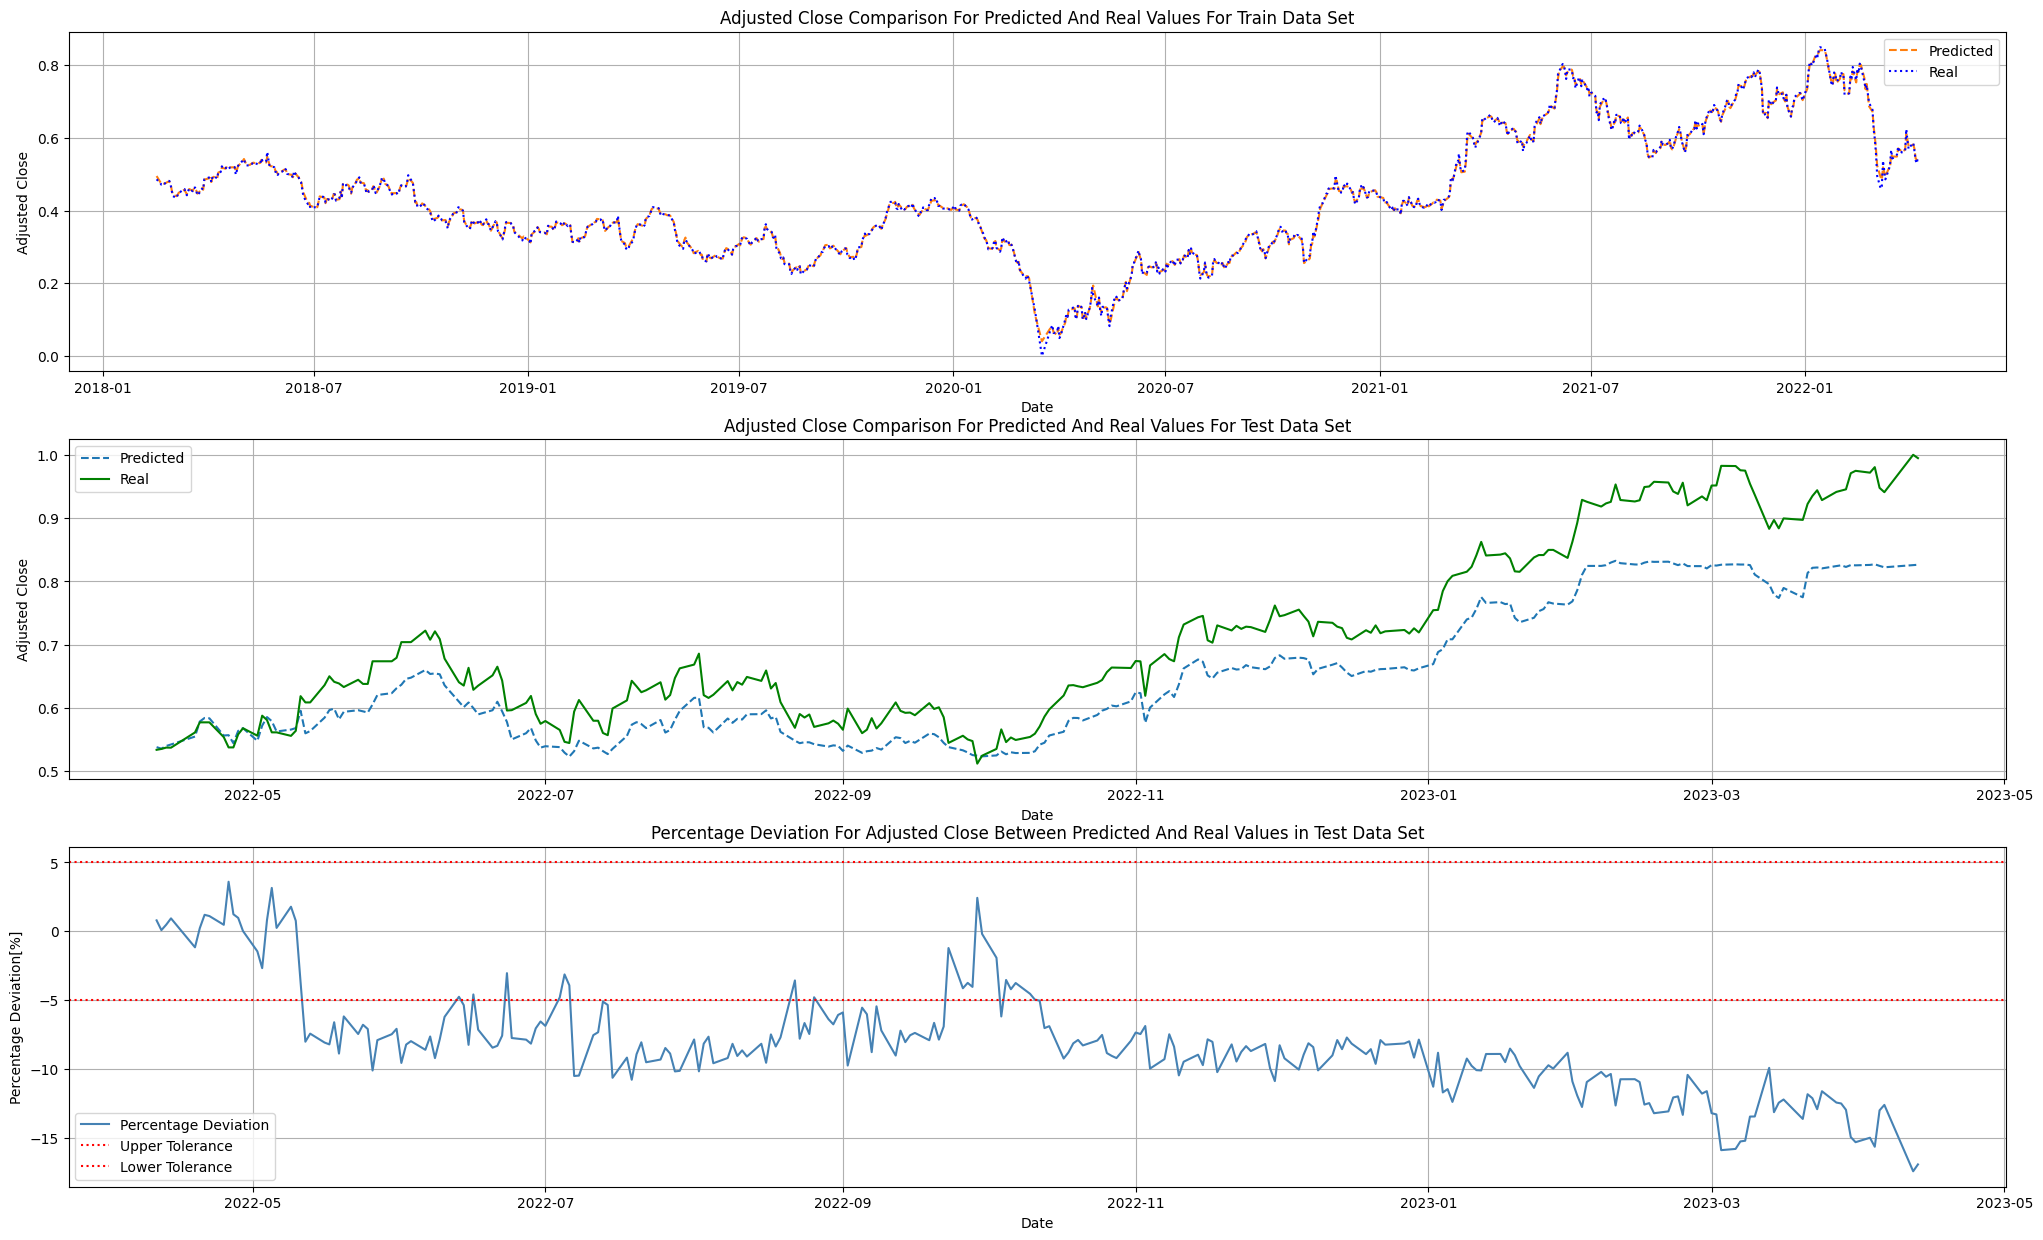

The mean for the percentage deviation in the test date is -8.132281666681275.

----------------

BTC-USD


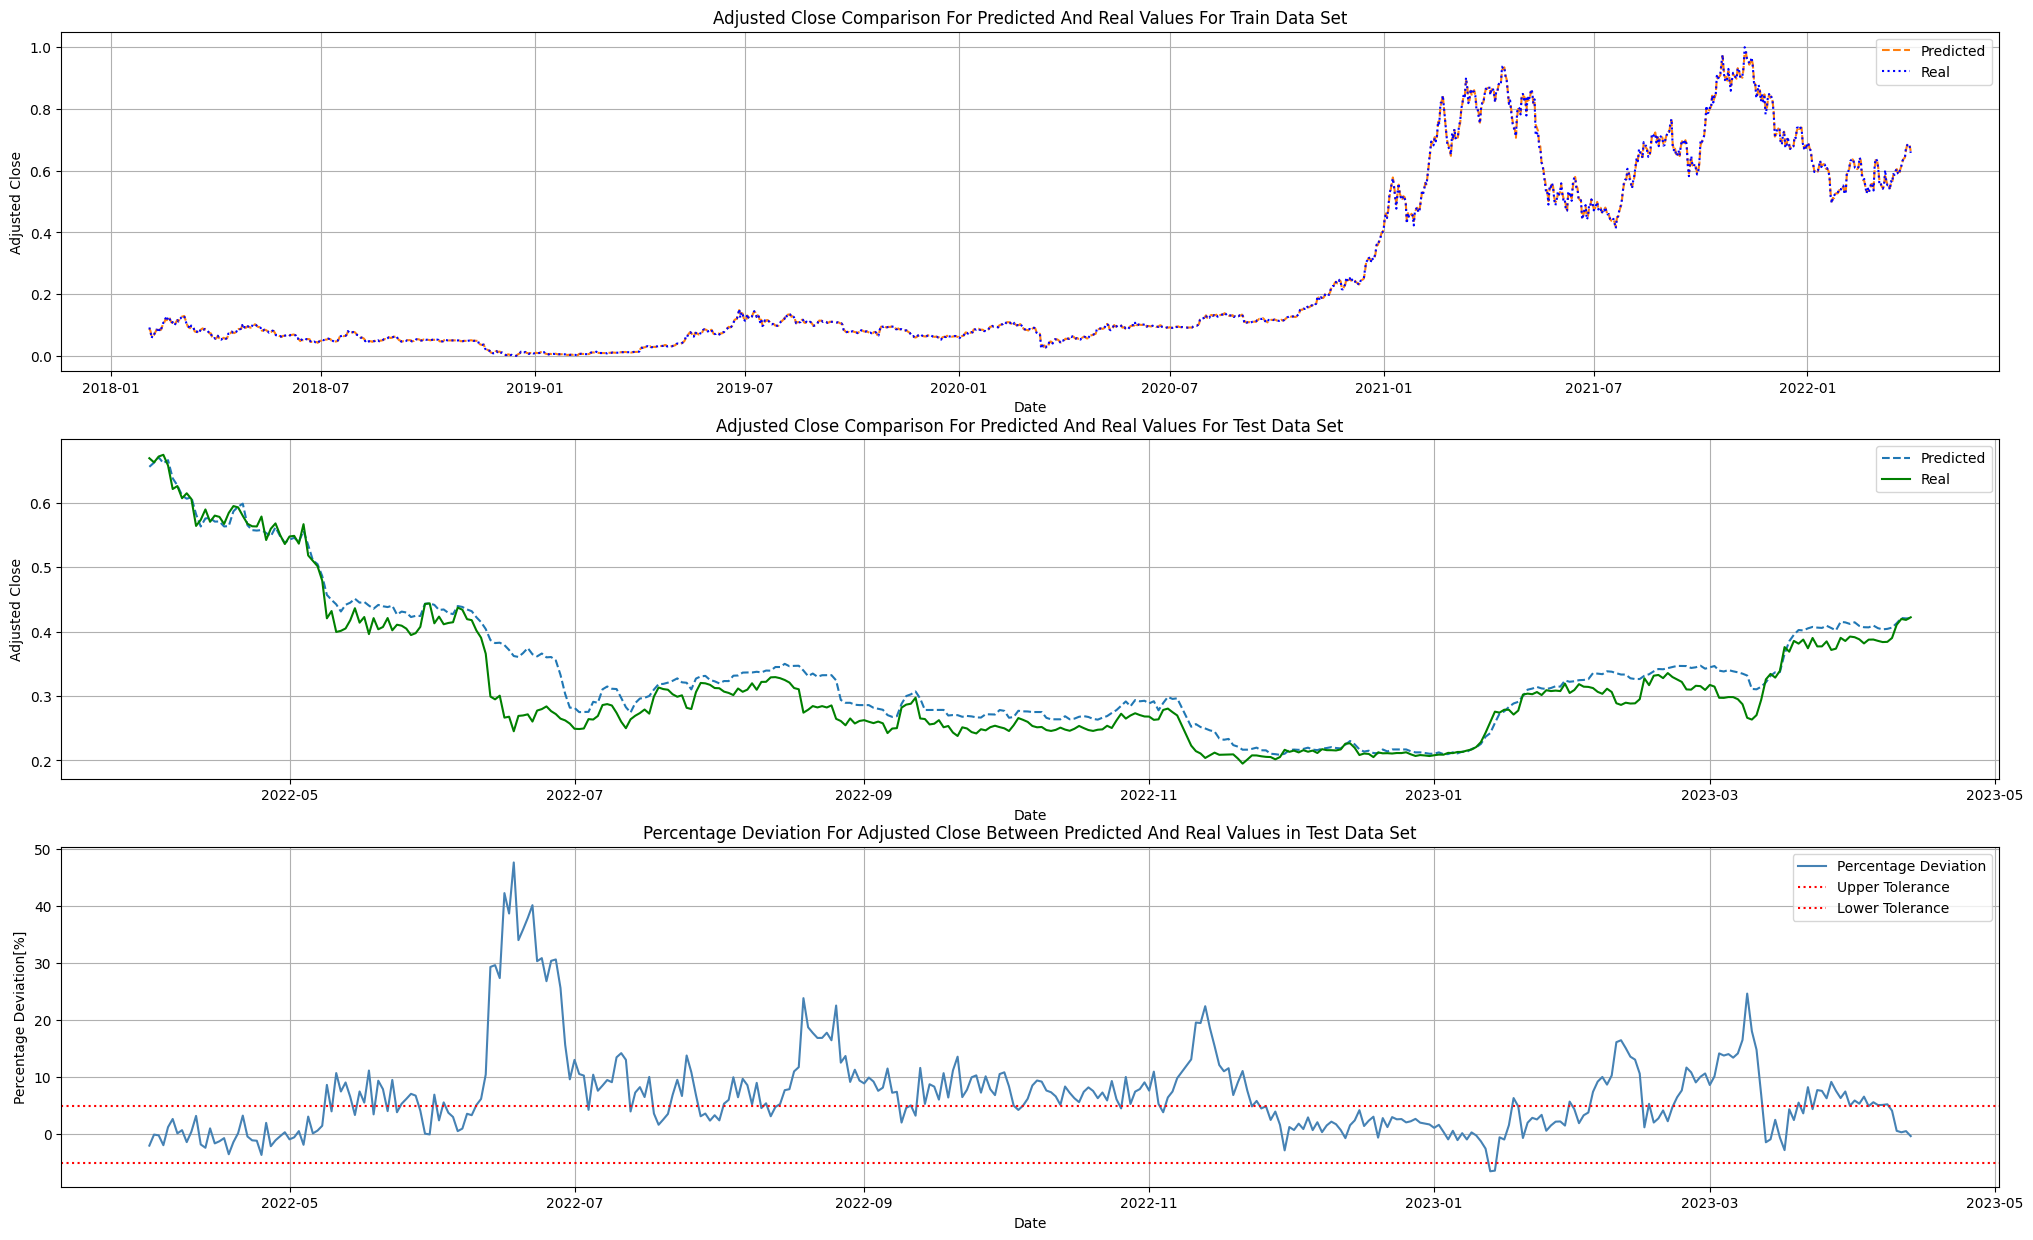

The mean for the percentage deviation in the test date is 7.048746442873698.

----------------

ETSY


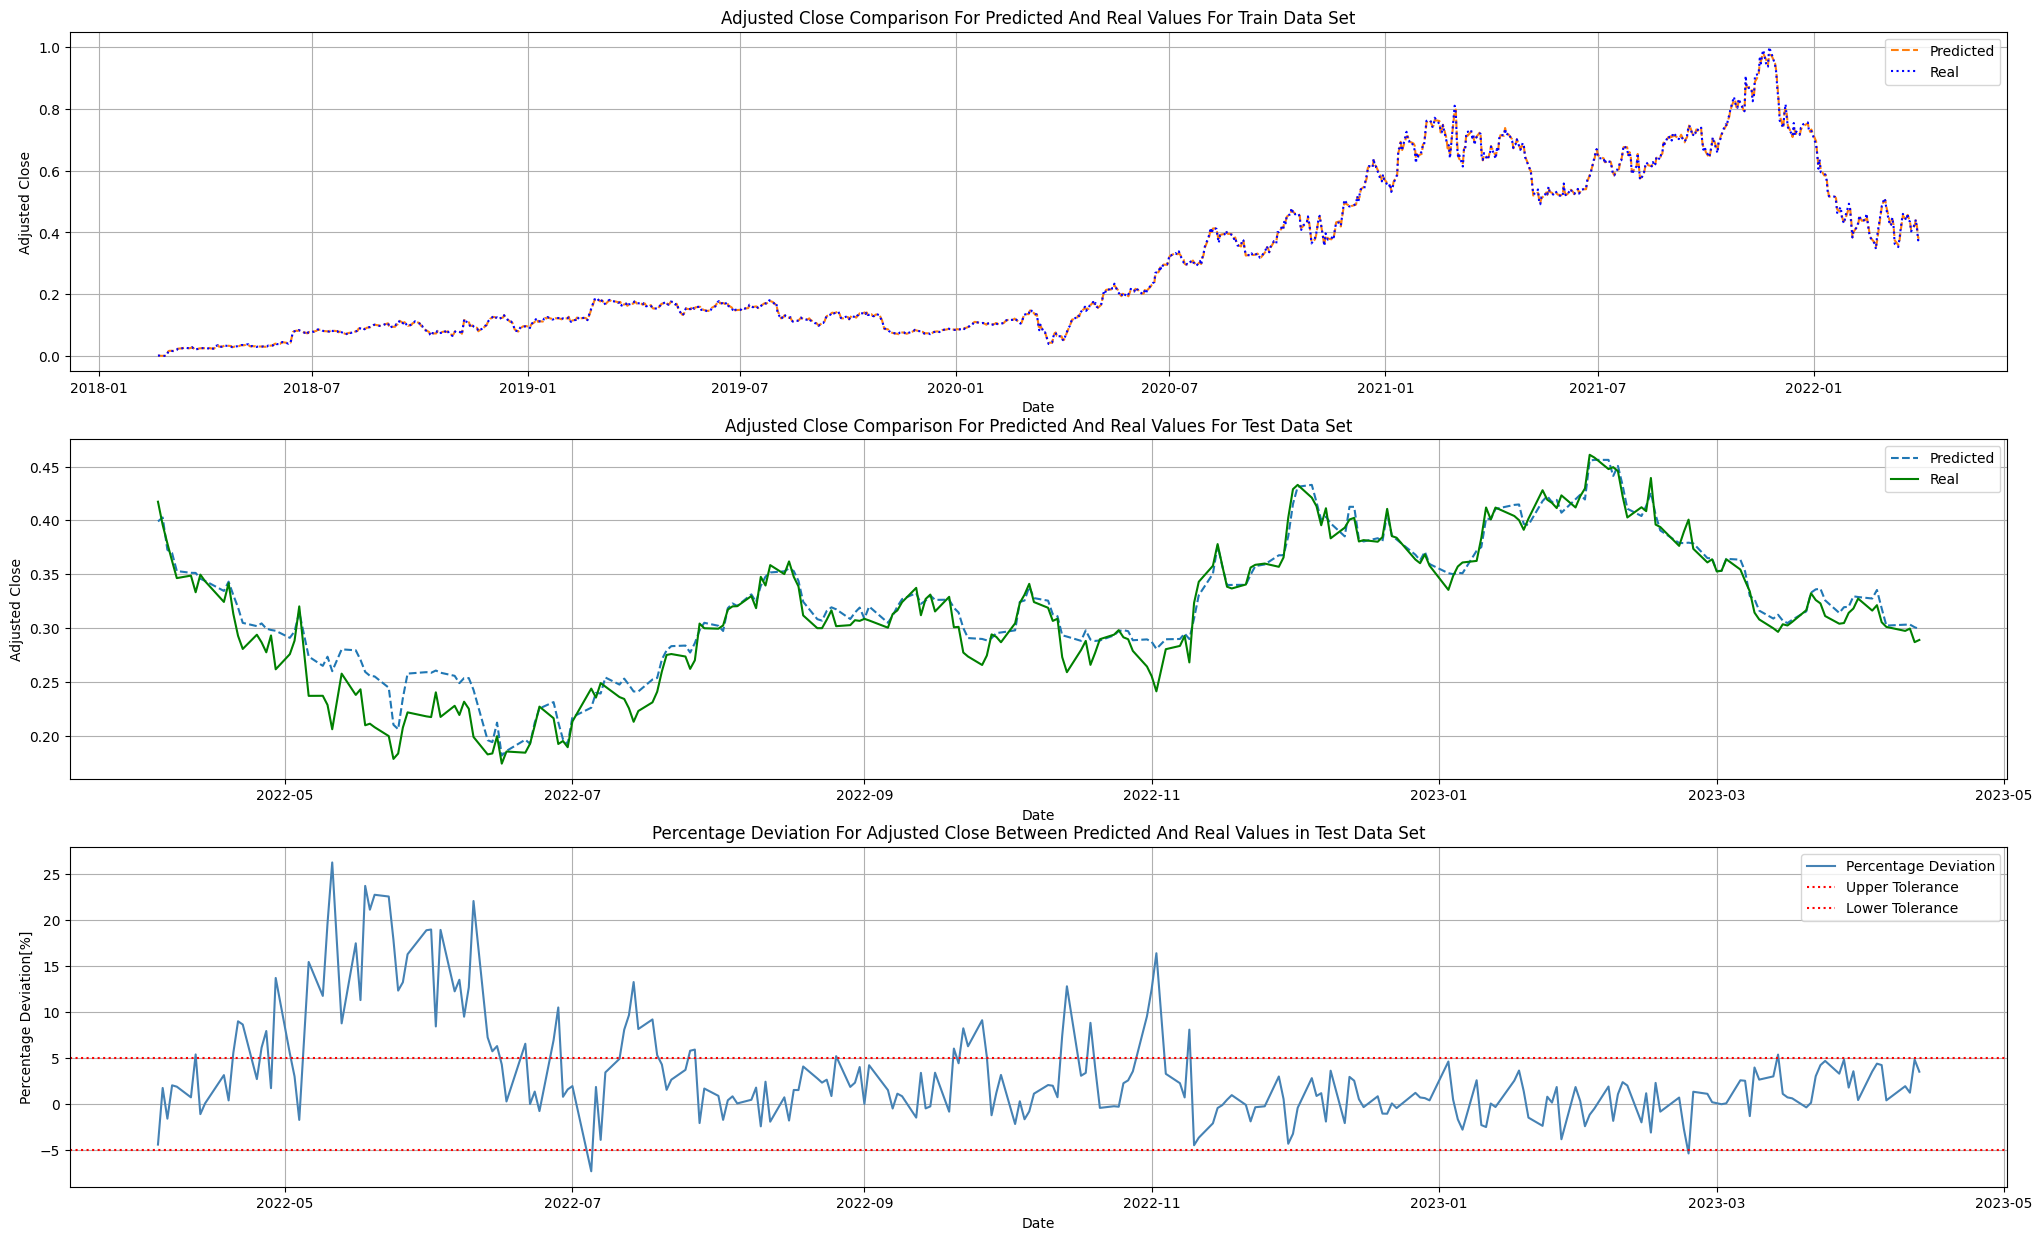

The mean for the percentage deviation in the test date is 3.3106058169864205.

----------------

JNJ


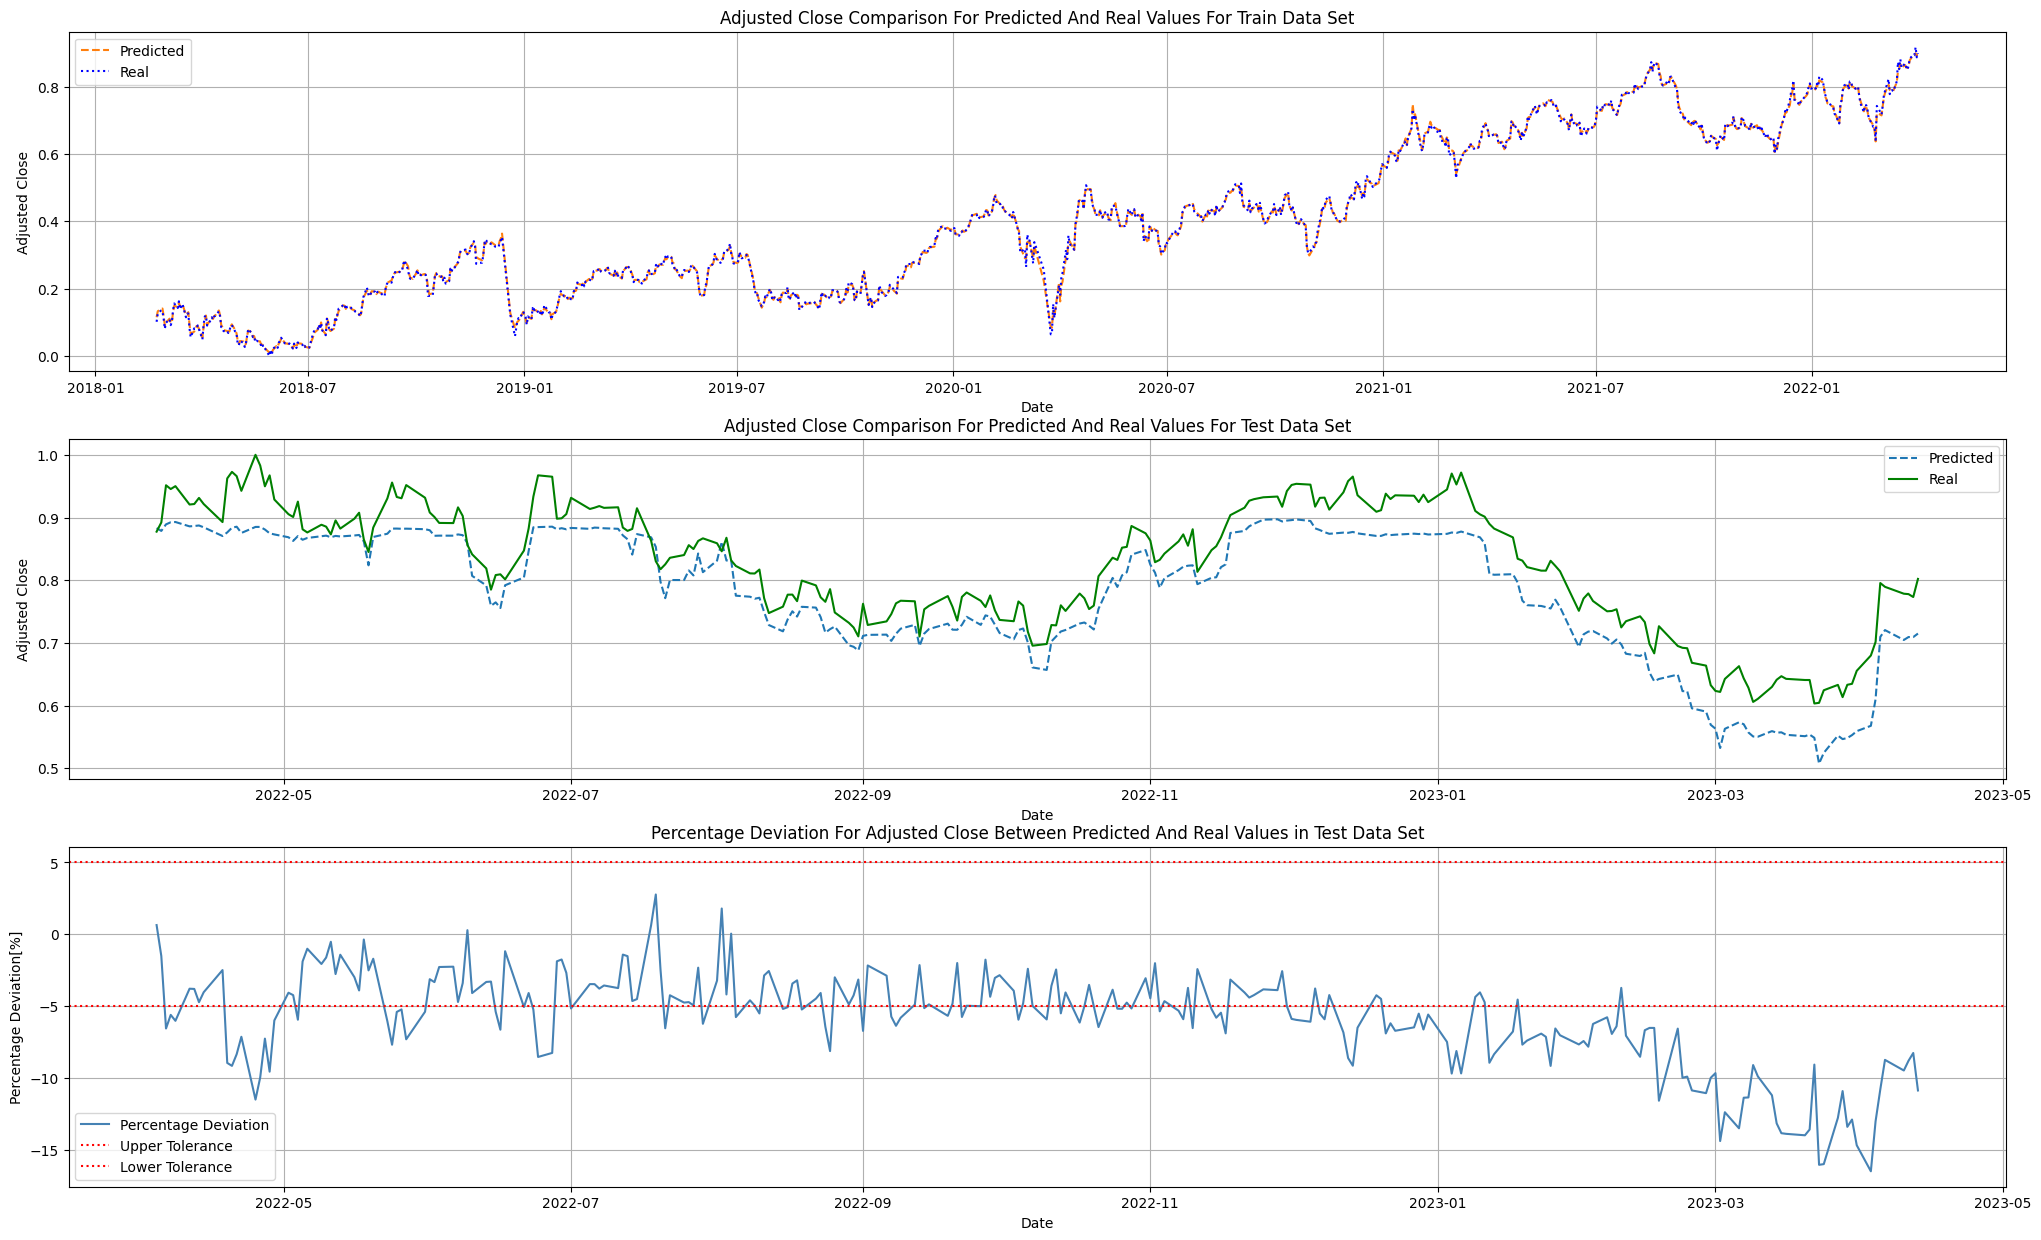

The mean for the percentage deviation in the test date is -5.822905056335316.

----------------

TSLA


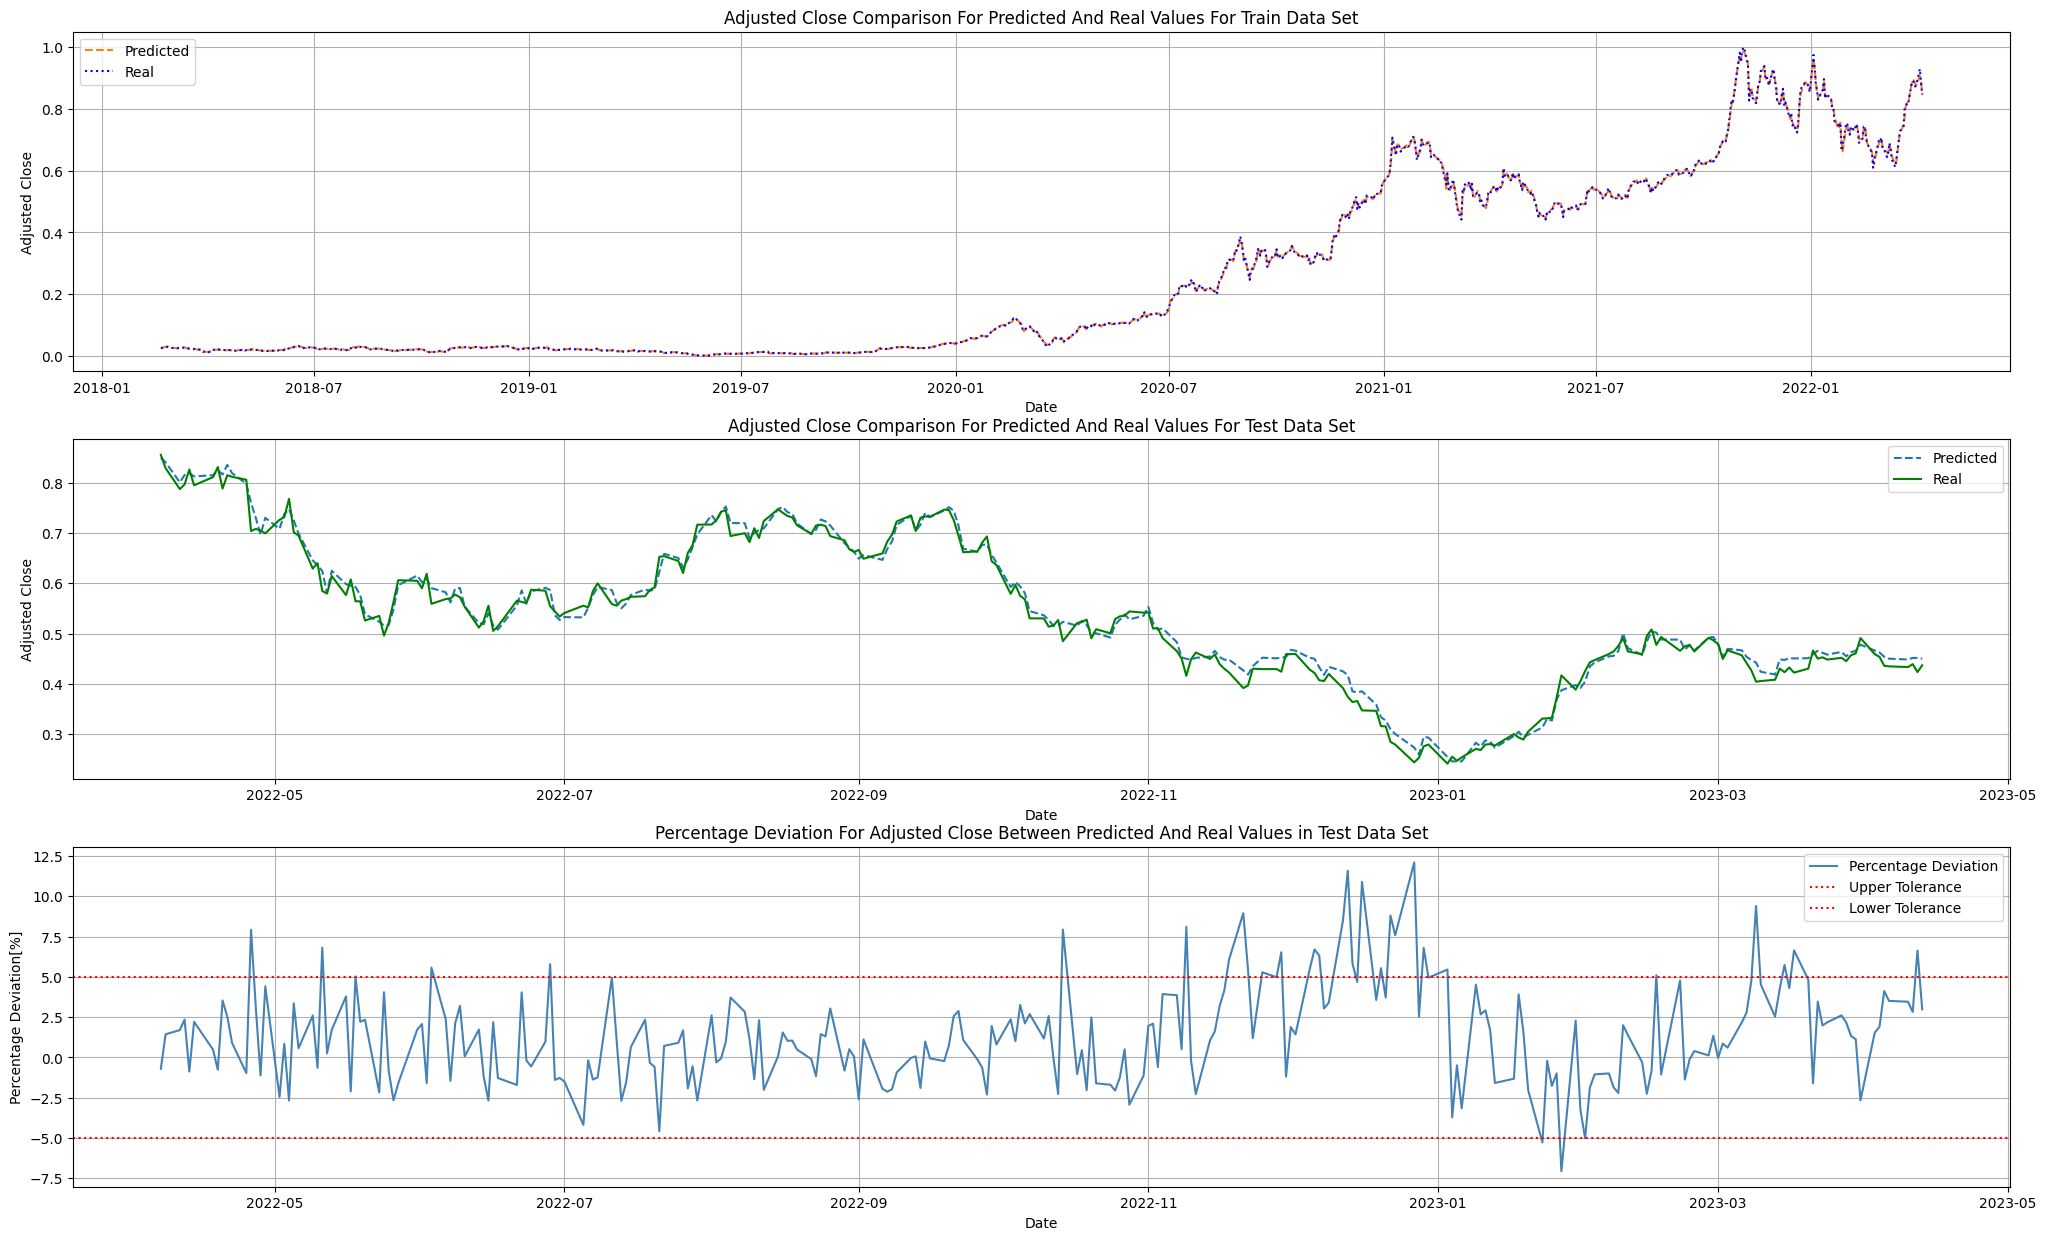

The mean for the percentage deviation in the test date is 1.3697049012029447.

----------------



In [10]:
# plot of the comparison between train and test data and the prediction

# iterate through the stocks
for name in Xs_train:
    
    print(name)
    
    # plot the comparison between predicted And real values for train data
    plt.figure()
    plt.close()
    plt.figure(figsize=(25, 15))
    plt.subplot(311)
    plt.plot(Xs_train[name].index, ys_train_predict[name], color='tab:orange', linestyle='--', label='Predicted')
    plt.plot(Xs_train[name].index, ys_train[name], color='blue', linestyle=':', label='Real')
    plt.grid()
    plt.legend()
    plt.ylabel('Adjusted Close')
    plt.xlabel('Date')
    plt.title('Adjusted Close Comparison For Predicted And Real Values For Train Data Set')
    
    # plot the comparison between predicted And real values for test data
    plt.subplot(312)
    plt.plot(Xs_test[name].index, ys_test_predict[name], color='tab:blue', linestyle='--', label='Predicted')
    plt.plot(Xs_test[name].index, ys_test[name], color='green', label='Real')
    plt.grid()
    plt.legend()
    plt.ylabel('Adjusted Close')
    plt.xlabel('Date')
    plt.title('Adjusted Close Comparison For Predicted And Real Values For Test Data Set')
    
    # plot for percentage deviation between predicted and real values in test data 
    plt.subplot(313)
    diff_test = ys_test_predict[name]-ys_test[name]
    rel_diff_test = diff_test / ys_test[name]
    percent_diff_test = rel_diff_test * 100
    plt.plot(percent_diff_test.index, percent_diff_test, color='steelblue', label='Percentage Deviation')
    plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
    plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
    plt.grid()
    plt.legend()
    plt.ylabel('Percentage Deviation[%]')
    plt.xlabel('Date')
    plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
    plt.show()
    print('The mean for the percentage deviation in the test date is {}.'.format(sum(percent_diff_test)/len(percent_diff_test)))
    print('')
    print('----------------')
    print('')

With the same conditions, just TSLA and ETSY hold the ±5% tolerance for the prediction.
That's why, the Random Forest algorithm is not enough for my specification.

**Interesting fact**: On the one hand, stocks, which are more stable in their course, tend to be worse in the prediction. For example BMW.
On the other hand, stock which are more volatile, like TSLA, were better predicted. 

## <a class="anchor" id="lstm"> 4. LSTM </a>

In [241]:
def train_test_lstm(Xs_nor, ys_nor, window_size):
    '''
    Create new features for the X dfs
    
    INPUT 
    Xs_nor - (dict) Cleaned and normalized feature dfs of the stocks 
    ys_nor - (dict) Normalized target variables of the stocks
      
    OUTPUT
    Xs_train -
    Xs_test -
    ys_train -
    ys_test - 
    '''
    
    Xs_train = {}
    Xs_test = {}
    Xs_val = {}
    ys_train = {}
    ys_val = {}
    ys_test = {}
    
    
    for name in Xs_nor:
        X = Xs_nor[name]
        y = ys_nor[name]
        
        
        X_np = X.to_numpy()
        y_np = y.to_numpy()
        
        X, y = [], []
        for i in range(len(X_np)-window_size):
            row = [r for r in X_np[i:i+window_size]]
            X.append(row)
            label = y_np[i+window_size]
            y.append(label)
            

        
        
        
        train_size = int(len(X) * 0.6)
        val_size = train_size + int(len(X) * 0.2)
        X_train, X_val, X_test = X[:train_size], X[train_size:val_size], X[val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:val_size], y[val_size:]
        
        Xs_train[name] = X_train
        Xs_val[name] = X_val
        Xs_test[name] = X_test
        ys_train[name] = y_train
        ys_val[name] = y_val
        ys_test[name] = y_test
        
    return Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test

In [242]:
Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(Xs_nor, ys_nor, 10)

In [ ]:
def ltsm_model(Xs_nor, ys_nor):
    model1 = Sequential()
    model1.add(InputLayer((10, 15)))
    model1.add(LSTM(64))
    model1.add(Dense(8, 'relu'))
    model1.add(Dense(1, 'linear'))
    
    cp1 = ModelCheckpoint('model1/', save_best_only=True)
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    
    for name in Xs_nor
    model1.fit(np.array(Xs_train['JNJ']), np.array(ys_train['JNJ']), validation_data=(np.array(Xs_val['JNJ']), np.array(ys_val['JNJ'])), epochs=50, callbacks=[cp1])


In [243]:
model1 = Sequential()
model1.add(InputLayer((10, 15)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                20480     
                                                                 
 dense_38 (Dense)            (None, 8)                 520       
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 21,009
Trainable params: 21,009
Non-trainable params: 0
_________________________________________________________________


In [244]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [245]:
np.array(ys_train['TSLA']).shape

(759,)

In [246]:
np.array(Xs_train['TSLA']).shape

(759, 10, 15)

In [247]:
model1.fit(np.array(Xs_train['JNJ']), np.array(ys_train['JNJ']), validation_data=(np.array(Xs_val['JNJ']), np.array(ys_val['JNJ'])), epochs=50, callbacks=[cp1])





Epoch 1/50
16/24 [===================>..........] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0635 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 3s 112ms/step - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 2/50
16/24 [===================>..........] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0416

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 75ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 3/50
17/24 [====================>.........] - ETA: 0s - loss: 8.7489e-04 - root_mean_squared_error: 0.0296

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 76ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 7.9324e-04 - val_root_mean_squared_error: 0.0282
Epoch 4/50
17/24 [====================>.........] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0337    

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 75ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 7.1519e-04 - val_root_mean_squared_error: 0.0267
Epoch 5/50
24/24 [==============================] - 0s 4ms/step - loss: 9.0678e-04 - root_mean_squared_error: 0.0301 - val_loss: 7.3410e-04 - val_root_mean_squared_error: 0.0271
Epoch 6/50
17/24 [====================>.........] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0325

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 76ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 6.0985e-04 - val_root_mean_squared_error: 0.0247
Epoch 7/50
24/24 [==============================] - 0s 5ms/step - loss: 8.1014e-04 - root_mean_squared_error: 0.0285 - val_loss: 8.9616e-04 - val_root_mean_squared_error: 0.0299
Epoch 8/50
24/24 [==============================] - 0s 5ms/step - loss: 7.8463e-04 - root_mean_squared_error: 0.0280 - val_loss: 8.3547e-04 - val_root_mean_squared_error: 0.0289
Epoch 9/50
24/24 [==============================] - 0s 5ms/step - loss: 8.2233e-04 - root_mean_squared_error: 0.0287 - val_loss: 8.9657e-04 - val_root_mean_squared_error: 0.0299
Epoch 10/50
24/24 [==============================] - 0s 4ms/step - loss: 7.3439e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 11/50
24/24 [==============================] - 0s 4ms/step - loss: 9.2524e-04 - root_mean_squared_error: 0.0304 - val_los

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 76ms/step - loss: 6.7084e-04 - root_mean_squared_error: 0.0259 - val_loss: 5.8332e-04 - val_root_mean_squared_error: 0.0242
Epoch 14/50
24/24 [==============================] - 0s 4ms/step - loss: 8.4567e-04 - root_mean_squared_error: 0.0291 - val_loss: 8.5180e-04 - val_root_mean_squared_error: 0.0292
Epoch 15/50
17/24 [====================>.........] - ETA: 0s - loss: 6.6901e-04 - root_mean_squared_error: 0.0259

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 101ms/step - loss: 6.5669e-04 - root_mean_squared_error: 0.0256 - val_loss: 5.3426e-04 - val_root_mean_squared_error: 0.0231
Epoch 16/50
24/24 [==============================] - 0s 4ms/step - loss: 6.2658e-04 - root_mean_squared_error: 0.0250 - val_loss: 5.7334e-04 - val_root_mean_squared_error: 0.0239
Epoch 17/50
24/24 [==============================] - 0s 4ms/step - loss: 7.4807e-04 - root_mean_squared_error: 0.0274 - val_loss: 6.0931e-04 - val_root_mean_squared_error: 0.0247
Epoch 18/50
24/24 [==============================] - 0s 4ms/step - loss: 6.4401e-04 - root_mean_squared_error: 0.0254 - val_loss: 6.5501e-04 - val_root_mean_squared_error: 0.0256
Epoch 19/50
24/24 [==============================] - 0s 4ms/step - loss: 7.1099e-04 - root_mean_squared_error: 0.0267 - val_loss: 9.8002e-04 - val_root_mean_squared_error: 0.0313
Epoch 20/50
24/24 [==============================] - 0s 4ms/step - loss: 7.3546e-04 - root_mean_squared_error: 0.02

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 75ms/step - loss: 5.9818e-04 - root_mean_squared_error: 0.0245 - val_loss: 5.2499e-04 - val_root_mean_squared_error: 0.0229
Epoch 33/50
24/24 [==============================] - 0s 4ms/step - loss: 5.9450e-04 - root_mean_squared_error: 0.0244 - val_loss: 8.6505e-04 - val_root_mean_squared_error: 0.0294
Epoch 34/50
24/24 [==============================] - 0s 4ms/step - loss: 5.3625e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 35/50
24/24 [==============================] - 0s 4ms/step - loss: 5.5490e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 36/50
24/24 [==============================] - 0s 4ms/step - loss: 6.4045e-04 - root_mean_squared_error: 0.0253 - val_loss: 5.2740e-04 - val_root_mean_squared_error: 0.0230
Epoch 37/50
24/24 [==============================] - 0s 4ms/step - loss: 6.4349e-04 - root_mean_squared_error: 0.0254 - val_

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 75ms/step - loss: 5.4026e-04 - root_mean_squared_error: 0.0232 - val_loss: 5.1213e-04 - val_root_mean_squared_error: 0.0226
Epoch 48/50
17/24 [====================>.........] - ETA: 0s - loss: 3.8624e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


24/24 [==============================] - 2s 75ms/step - loss: 5.2967e-04 - root_mean_squared_error: 0.0230 - val_loss: 4.1419e-04 - val_root_mean_squared_error: 0.0204
Epoch 49/50
24/24 [==============================] - 0s 5ms/step - loss: 5.9997e-04 - root_mean_squared_error: 0.0245 - val_loss: 4.2789e-04 - val_root_mean_squared_error: 0.0207
Epoch 50/50
24/24 [==============================] - 0s 4ms/step - loss: 5.1530e-04 - root_mean_squared_error: 0.0227 - val_loss: 5.5165e-04 - val_root_mean_squared_error: 0.0235


In [248]:
model1 = load_model('model1/')

In [249]:
train_predictions = model1.predict(np.array(Xs_test['JNJ'])).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':np.array(ys_test['JNJ'])})
train_results

8/8 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,0.870830,0.892105
1,0.881398,0.951447
2,0.914527,0.945410
3,0.915186,0.950034
4,0.922187,0.920749
...,...,...
248,0.781343,0.789468
249,0.795105,0.778518
250,0.795615,0.777859
251,0.803073,0.773241


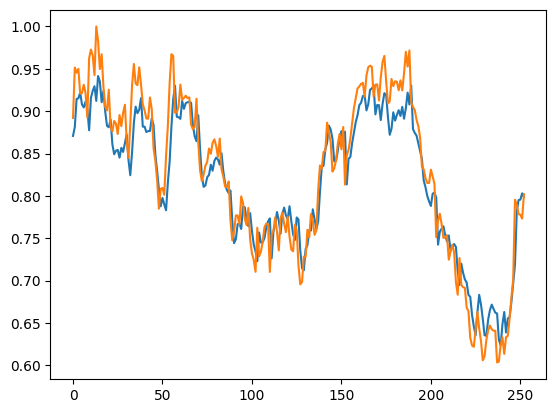

In [250]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

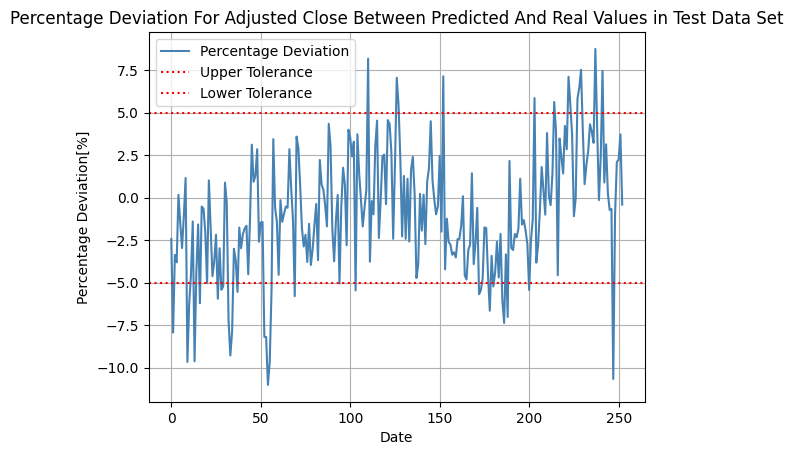

The mean for the percentage deviation in the test date is -0.9085801332194646.

----------------



In [252]:
   
# plot for percentage deviation between predicted and real values in test data 
diff_test = train_results['Train Predictions']-train_results['Actuals']
rel_diff_test = diff_test / train_results['Train Predictions']
percent_diff_test = rel_diff_test * 100
plt.plot(percent_diff_test.index, percent_diff_test, color='steelblue', label='Percentage Deviation')
plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
plt.grid()
plt.legend()
plt.ylabel('Percentage Deviation[%]')
plt.xlabel('Date')
plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
plt.show()
print('The mean for the percentage deviation in the test date is {}.'.format(sum(percent_diff_test)/len(percent_diff_test)))
print('')
print('----------------')
print('')

In [255]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf

# Daten laden
symbol = "AAPL"
data = yf.download(symbol, start="2010-01-01", end="2023-04-28")
data = data[["Adj Close"]]

# Daten skalieren
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Trainingsdaten erstellen
look_back = 30
X_train = []
y_train = []

for i in range(look_back, len(data_scaled)):
    X_train.append(data_scaled[i - look_back:i, 0])
    y_train.append(data_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# LSTM-Modell erstellen
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Vorhersage für 20 Tage in der Zukunft
n_future_days = 20
input_data = data_scaled[-look_back:].reshape(1, -1)
for _ in range(n_future_days):
    input_data_reshaped = input_data.reshape((1, look_back, 1))
    predicted_value = model.predict(input_data_reshaped)
    input_data = np.append(input_data[:, 1:, :], predicted_value, axis=1)



predicted_price = scaler.inverse_transform(input_data[-1].reshape(-1, 1))[0, 0]
print(f"Vorhersage für den Aktienkurs von {symbol} in 20 Tagen: {predicted_price:.2f}")


[*********************100%***********************]  1 of 1 completed
Epoch 1/10
104/104 [==============================] - 3s 14ms/step - loss: 0.0065
Epoch 2/10
104/104 [==============================] - 2s 15ms/step - loss: 4.0281e-04
Epoch 3/10
104/104 [==============================] - 2s 15ms/step - loss: 3.5212e-04
Epoch 4/10
104/104 [==============================] - 2s 15ms/step - loss: 3.4034e-04
Epoch 5/10
104/104 [==============================] - 2s 15ms/step - loss: 3.0316e-04
Epoch 6/10
104/104 [==============================] - 2s 15ms/step - loss: 3.0019e-04
Epoch 7/10
104/104 [==============================] - 2s 15ms/step - loss: 2.8753e-04
Epoch 8/10
104/104 [==============================] - 2s 15ms/step - loss: 2.7802e-04
Epoch 9/10
104/104 [==============================] - 2s 15ms/step - loss: 2.9819e-04
Epoch 10/10
1/1 [==============================] - 0s 332ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [270]:
# to do: 
# train function: richtig kommentieren
# in der process programm immer das aktuelle datum als enddatum verwenden
# feat_eng function: richtig kommentieren
# funktion schreiben, die die besten window size findet
# herausfinden, wie ich ich auf basis von bestimmte anzahl von tagen einen wert predicte
# => immer einen tag predicten  und dann den nächsten und den näcshten Beispiel Code:
Um mit einem trainierten Zeitreihen-Machine-Learning-Modell mehrere Tage in die Zukunft vorherzusagen, können Sie entweder eine rekursive Strategie oder ein "direct multi-step forecasting" verwenden. Ich werde hier die rekursive Strategie erklären, bei der das Modell iterativ verwendet wird, um Vorhersagen für die nächsten Tage zu treffen, indem die vorhergesagten Werte als Eingabe für die zukünftigen Vorhersagen verwendet werden.

Angenommen, Sie haben ein trainiertes Modell und möchten für einen bestimmten Tag und die nächsten n_days in der Zukunft vorhersagen. Hier ist ein Beispiel in Python, wie Sie dies tun können:

python

def predict_future(model, input_data, n_days, scaler=None):
    future_predictions = []

    for _ in range(n_days):
        # Vorhersage für den nächsten Tag
        predicted_value_scaled = model.predict(input_data)
        
        # Skalierten Wert in die ursprüngliche Skala zurückverwandeln, falls notwendig
        if scaler is not None:
            predicted_value = scaler.inverse_transform(predicted_value_scaled)
        else:
            predicted_value = predicted_value_scaled

        # Füge die Vorhersage der Liste der zukünftigen Vorhersagen hinzu
        future_predictions.append(predicted_value[0, 0])

        # Aktualisiere die Eingabedaten, indem du den vorhergesagten Wert hinzufügst
        input_data = np.append(input_data[:, 1:], predicted_value_scaled)
        input_data = input_data.reshape((1, input_data.shape[0], 1))

    return future_predictions

Definition des Abfrageprozesses:
- User gibt Aktien ein, die in interessieren (einzel oder Liste)

- Daten beschaffen:
    - Immer das aktuelle Datum verwenden 
    - 10 Jahre hinter diesem Datum daten ziehen 
    - Daten über meinen aktuellen Algo beschaffen, bereinigen und speichern
    - User in einer Web App die Daten aufbereitet präsentieren 
    
    
- Daten verarbeitung:
    - Daten laden und feature engineering durchführen
    - LTSM trainieren (50 Epochen, inklusiere finden des besten window-fensters)
    - Zukunftswerte predicten: 7, 14, 28 Tage
        - Brechnung der Werte für einen Tage (Test_data) => letzten tag löschen und dann mit dem neuen Tag den nächsten Tag berechnen => Diese Werte in eine separate Liste speichern
        - In wie genau der Algo ist (in Prozent)
  
  
     - Kunden Visualisierung:
         - Testdaten zeigen in einer Farbe
         - Zukunftswerte (Kursentwicklung) in einer anderen Farbe
         - Empfehlung schreiben:
             - Ist der Wert größer nach 28 Tage: Behalten
             - kleiner: verkaufen

In [282]:
import datetime
today = datetime.date.today()

today_trans = today.strftime("%d-%m-%Y")

start_date = today - datetime.timedelta(days=365*10)

start_date = start_date.strftime("%d-%m-%Y")

In [274]:
today.

datetime.date(2023, 4, 29)

In [275]:
start_date

'01-05-2013'

In [23]:
import matplotlib.pyplot as plt
import os


def generate_visualizations(data):

    file_names = []
    for stock_name in data:
        window_size = 20
        
        plt.figure(figsize=(25, 15))
        # calculate the rolling average
        rolling_mean_high = data[stock_name]['High'].rolling(window_size).mean()
        rolling_mean_low = data[stock_name]['Low'].rolling(window_size).mean()

        # plot rolling mean variants
        plt.plot(rolling_mean_high, label="Rolling Mean High")
        plt.plot(rolling_mean_low, label="Rolling Mean Low")
        plt.legend(loc='upper left')
        plt.ylabel('Stock Price Rolling Average')
        plt.grid()

        # save the plot
        filename = f'{stock_name}_stock.png'
        filepath = os.path.join(app.static_folder, filename)
        plt.savefig(filepath)
        file_names.append(filename)

    return file_names

NameError: name 'app' is not defined

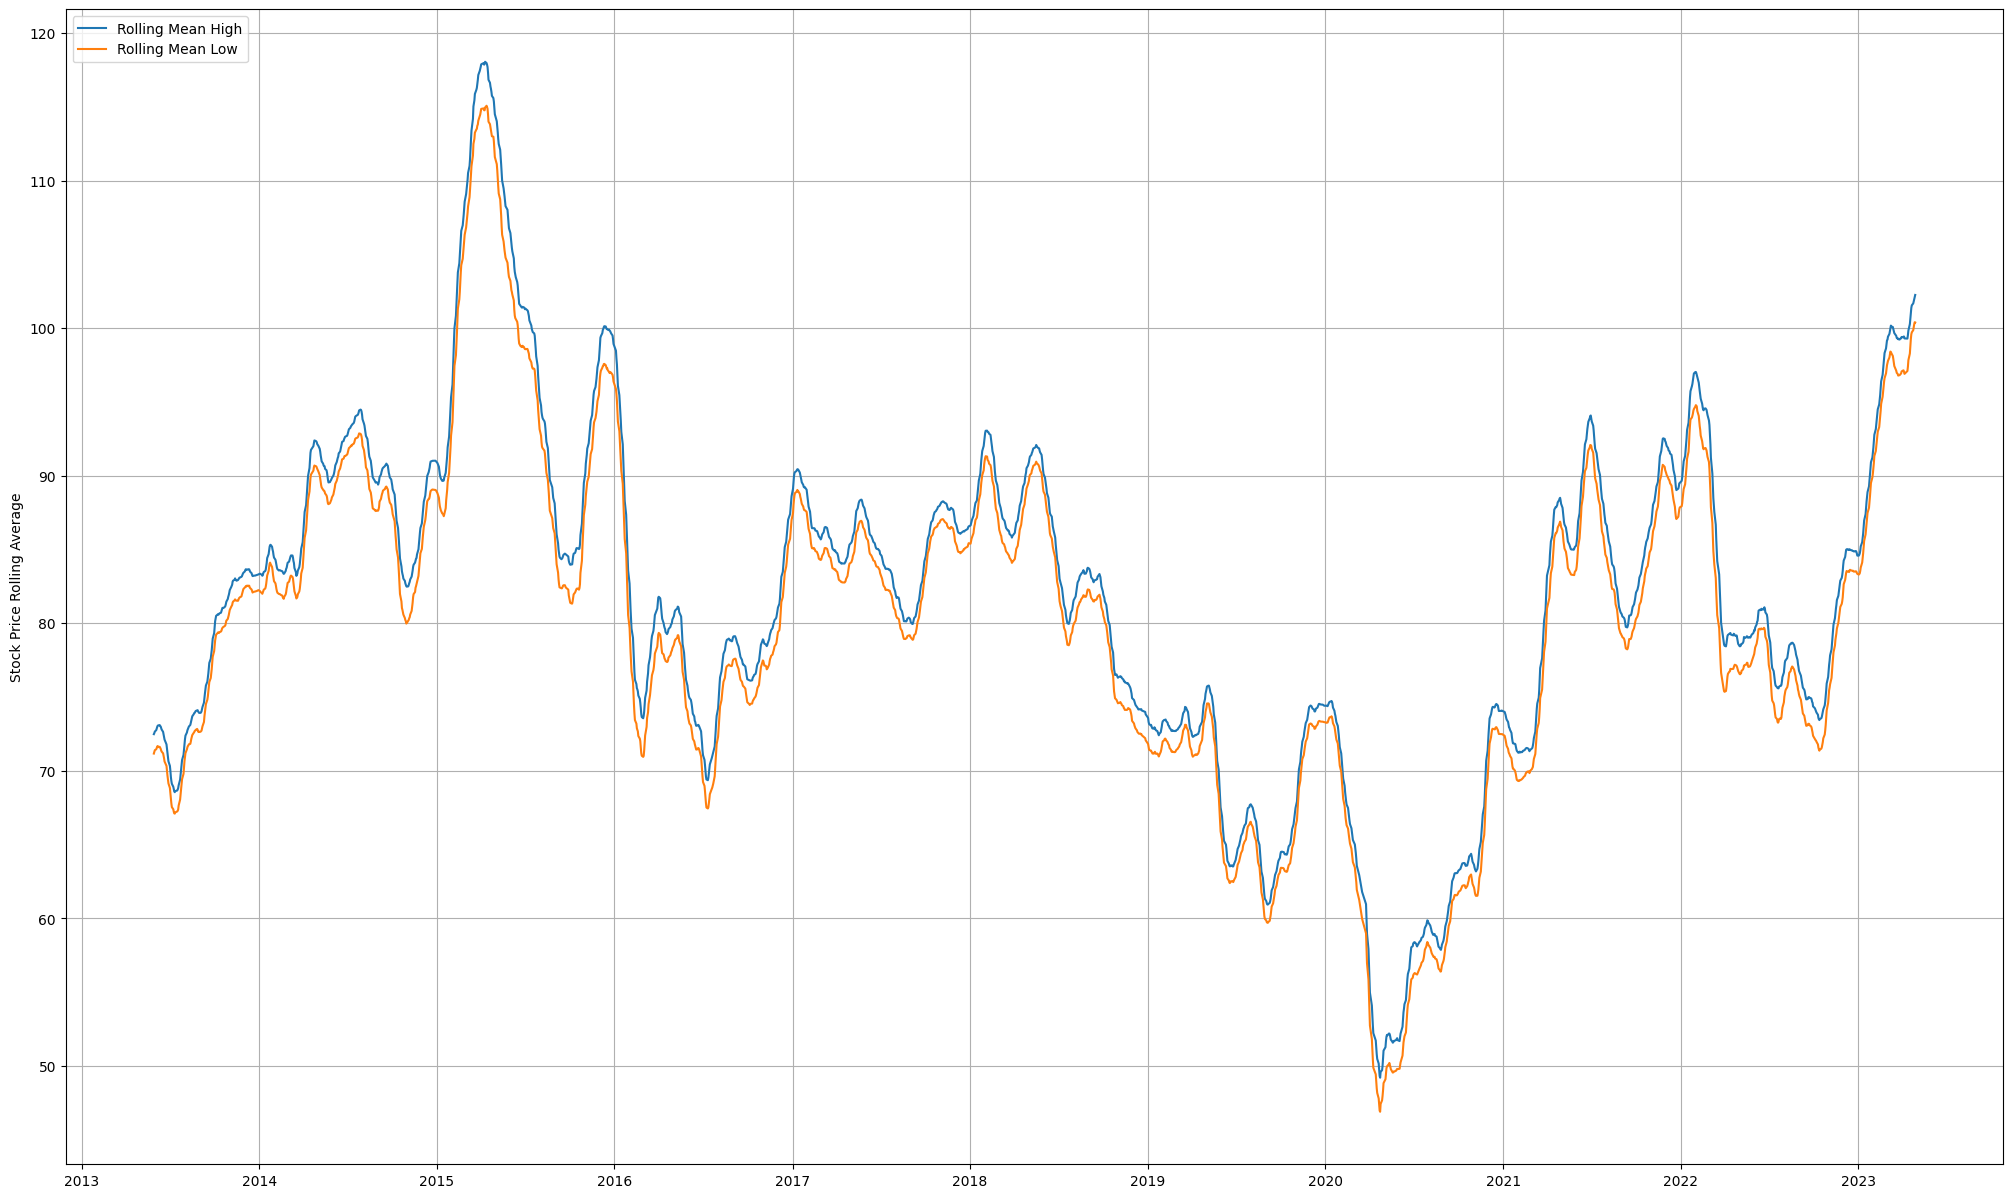

In [24]:
generate_visualizations(Xs)

In [12]:
dfs

{'TSLA':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2013-05-02    3.590000    3.684667    3.580000    3.607333    3.607333   
 2013-05-03    3.764667    3.764667    3.633333    3.636667    3.636667   
 2013-05-06    3.759333    3.977333    3.700000    3.966667    3.966667   
 2013-05-07    4.133333    4.158000    3.674667    3.700667    3.700667   
 2013-05-08    3.833333    3.880000    3.714000    3.719333    3.719333   
 ...                ...         ...         ...         ...         ...   
 2023-04-24  164.649994  165.649994  158.610001  162.550003  162.550003   
 2023-04-25  159.820007  163.470001  158.750000  160.669998  160.669998   
 2023-04-26  160.289993  160.669998  153.139999  153.750000  153.750000   
 2023-04-27  152.639999  160.479996  152.369995  160.190002  160.190002   
 2023-04-28  160.899994  165.000000  157.320007  164.309998  164.309998   
 
               